In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

import random

from tqdm import tqdm

import lightgbm as lgb
import xgboost as xgb
import joblib

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GroupKFold

from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import roc_curve, auc, accuracy_score, cohen_kappa_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score, confusion_matrix

/kaggle/input/ventilator-pressure-prediction/sample_submission.csv
/kaggle/input/ventilator-pressure-prediction/train.csv
/kaggle/input/ventilator-pressure-prediction/test.csv


### Google Brain - Ventilator Pressure Prediction

https://www.kaggle.com/c/ventilator-pressure-prediction

**Columns:**

**id** - globally-unique time step identifier across an entire file

**breath_id** - globally-unique time step for breaths

**R** - lung attribute indicating how restricted the airway is (in cmH2O/L/S). Physically, this is the change in pressure per change in flow (air volume per time). Intuitively, one can imagine blowing up a balloon through a straw. We can change R by changing the diameter of the straw, with higher R being harder to blow.

**C** - lung attribute indicating how compliant the lung is (in mL/cmH2O). Physically, this is the change in volume per change in pressure. Intuitively, one can imagine the same balloon example. We can change C by changing the thickness of the balloon’s latex, with higher C having thinner latex and easier to blow.

**time_step** - the actual time stamp.

**u_in** - the control input for the inspiratory solenoid valve. Ranges from 0 to 100.

**u_out** - the control input for the exploratory solenoid valve. Either 0 or 1.

**pressure** - the airway pressure measured in the respiratory circuit, measured in cmH2O.


In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        if col != 'time':
            col_type = df[col].dtypes
            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def get_stats(df):
    stats = pd.DataFrame(index=df.columns, columns=['na_count', 'n_unique', 'type', 'memory_usage'])
    for col in df.columns:
        stats.loc[col] = [df[col].isna().sum(), df[col].nunique(dropna=False), df[col].dtypes, df[col].memory_usage(deep=True, index=False) / 1024**2]
    stats.loc['Overall'] = [stats['na_count'].sum(), stats['n_unique'].sum(), None, df.memory_usage(deep=True).sum() / 1024**2]
    return stats

def print_header():
    print('col         conversion        dtype    na    uniq  size')
    print()
    
def print_values(name, conversion, col):
    template = '{:10}  {:16}  {:>7}  {:2}  {:6}  {:1.2f}MB'
    print(template.format(name, conversion, str(col.dtypes), col.isna().sum(), col.nunique(dropna=False), col.memory_usage(deep=True, index=False) / 1024 ** 2))
    
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    #tf.random.set_seed(seed)    
    
def draw_sequence( df, start, end, filter_out=None):
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 8))
    for i in range(start, end):
        if filter_out is not None and i in filter_out:
            continue
        df1 = df[df.breath_id == i]
        sns.lineplot( data = df1[['u_in']], ax=ax1)
        sns.lineplot( data = df1[['u_out']], ax=ax2)    
        sns.lineplot( data = df1[['pressure']], ax=ax3)    
        
def draw_in_out_pressure( df, breath_id1, breath_id2 ):
    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8))
    df1 = df[df.breath_id == breath_id1]
    sns.lineplot( data = df1[['u_in', 'u_out', 'pressure']], ax=ax1)
    df2 = df[df.breath_id == breath_id2]
    sns.lineplot( data = df2[['u_in', 'u_out', 'pressure']], ax=ax2)
        
def display_missing(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data.head()
    return missing_data       

def select_train_data(df, features, sample_size=1000, target_col='pressure'):
    TARGET_COL = target_col
    TRAIN_SIZE = WINDOW_SIZE*sample_size

    y = df[TARGET_COL][:TRAIN_SIZE]
    X = df[features][:TRAIN_SIZE]
    
    groups = df['breath_id'][:TRAIN_SIZE]
    print(f'Original sizes: train: {X.shape}, y_train: {y.shape}' )
    return X, y, groups

def select_test_data(df, start, features, sample_size=1000, target_col='pressure'):
    TARGET_COL = target_col
    TRAIN_SIZE = WINDOW_SIZE*sample_size

    X = df[features][start:start+TRAIN_SIZE]
    y = df[TARGET_COL][start:start+TRAIN_SIZE]
    print(f'Test sizes: start: {start}, X: {X.shape}' )
    return X, y

In [3]:
RANDOM_SEED = 42
WINDOW_SIZE = 80
DEBUG = True
HYPER_TUNING = False

seed_everything(RANDOM_SEED)

train = pd.read_csv('/kaggle/input/ventilator-pressure-prediction/train.csv')
test = pd.read_csv('/kaggle/input/ventilator-pressure-prediction/test.csv')
submission = pd.read_csv('/kaggle/input/ventilator-pressure-prediction/sample_submission.csv')

if DEBUG:
    train = train[:80*10000]

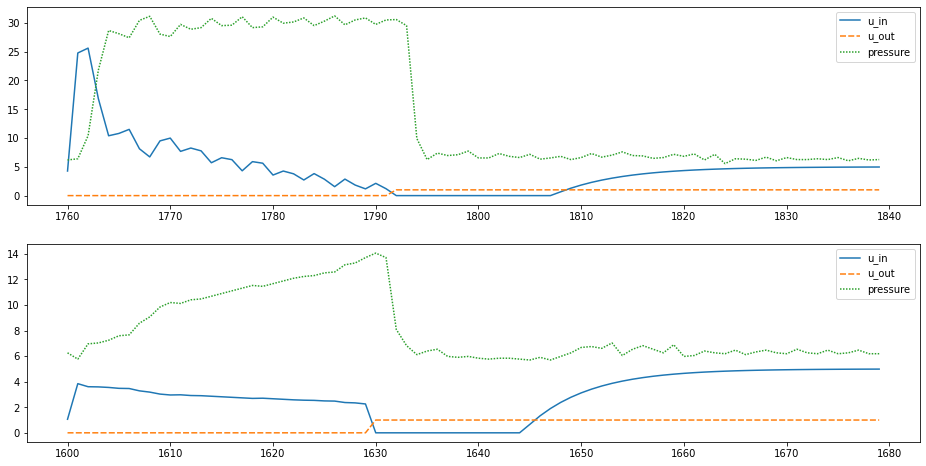

In [4]:
draw_in_out_pressure( train, 26, 23)

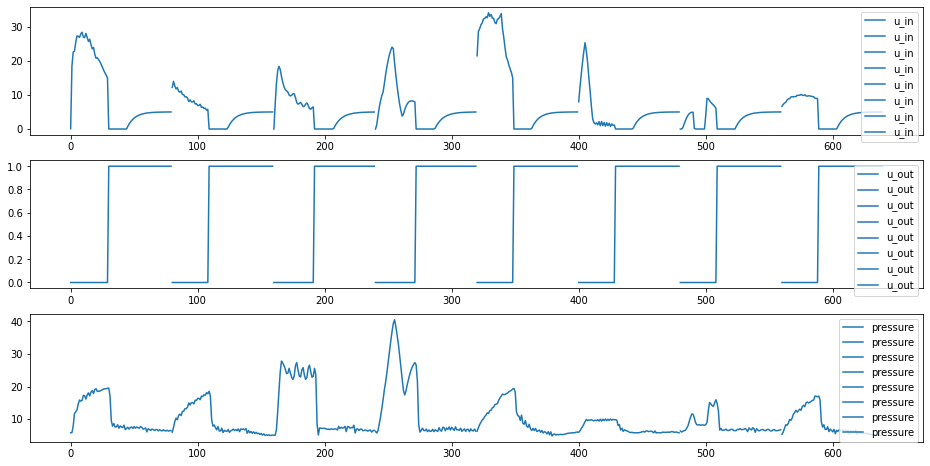

In [5]:
draw_sequence(train, 1, 10)

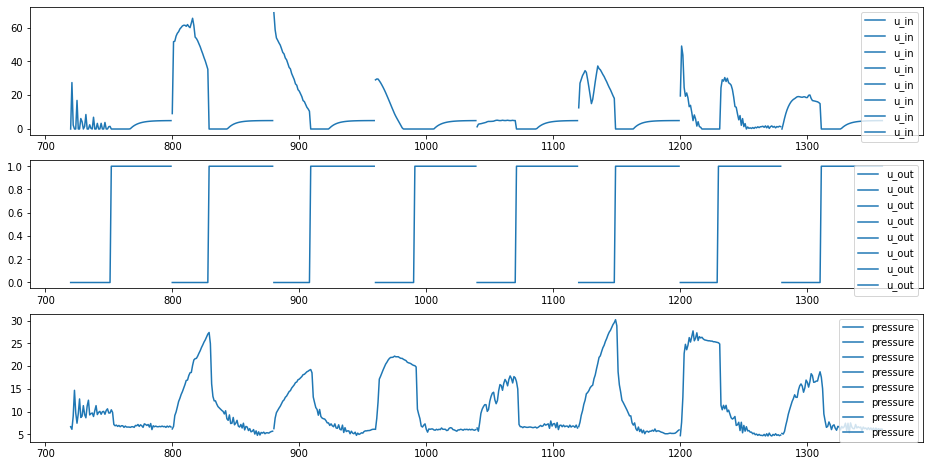

In [6]:
draw_sequence(train, 11, 20)

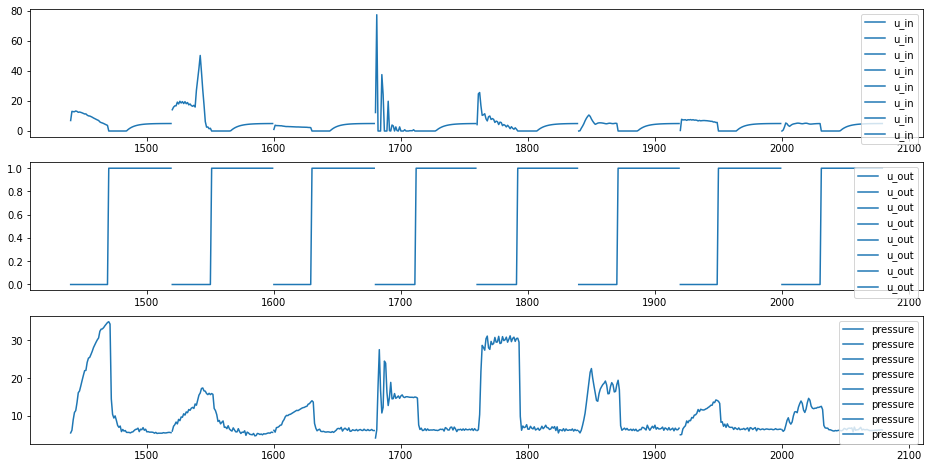

In [7]:
draw_sequence(train, 21, 30)

<AxesSubplot:xlabel='pressure', ylabel='Count'>

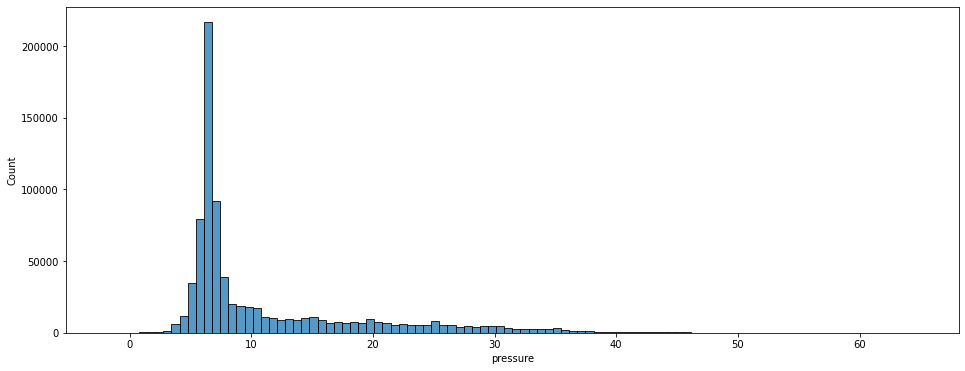

In [8]:
## target distribution
f, ax = plt.subplots(1, 1, figsize=(16, 6))
sns.histplot( x = train.pressure, ax=ax, bins=100)

## Outliers

<AxesSubplot:xlabel='pressure'>

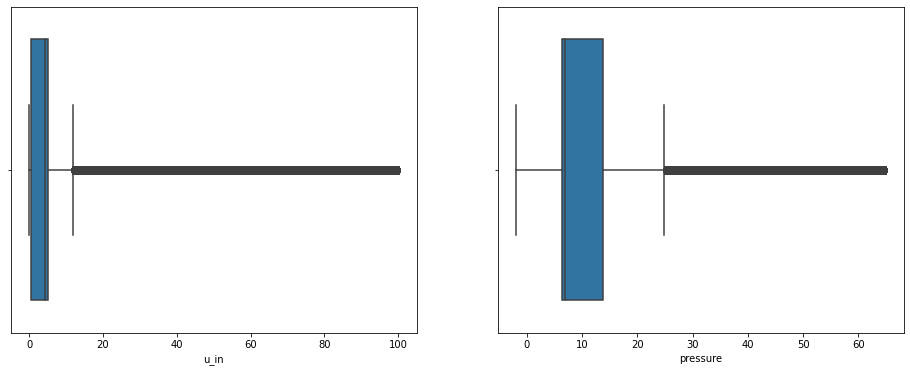

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
sns.boxplot( x = train.u_in, ax=ax1)
sns.boxplot( x = train.pressure, ax=ax2)

In [10]:
#train = pd.read_csv('/kaggle/input/ventilator-pressure-prediction/train.csv')
#u_in_arr = train.u_in.values.reshape(-1,80)

#outliers_idx = []
#for i in range(0, len(u_in_arr)):
#    if max(u_in_arr[i]) > 90:
#        outliers_idx.append(i)

#glb_mean = np.mean(u_in_arr)
        
# len = 1539
#print(len(outliers_idx))
#print(outliers_idx)

#for i in outliers_idx:
#    train[80*i:80*(i+1)] = -999
    #train.drop( train[80*i:80*(i+1)].index, inplace=True)

#train['outlier'] = train['u_in' == -999]

#dd = train.drop( train['u_in' == -999].index )
#print(len(dd))

In [11]:
#https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-1-4ece5098b755
    
#Tukey's method
def tukeys_method(df, variable):
    #Takes two parameters: dataframe & variable of interest as string
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3-q1
    inner_fence = 1.5*iqr
    outer_fence = 3*iqr
    
    #inner fence lower and upper end
    inner_fence_le = q1-inner_fence
    inner_fence_ue = q3+inner_fence
    
    #outer fence lower and upper end
    outer_fence_le = q1-outer_fence
    outer_fence_ue = q3+outer_fence
    
    outliers_prob = []
    outliers_poss = []
    for index, x in enumerate(df[variable]):
        if x <= outer_fence_le or x >= outer_fence_ue:
            outliers_prob.append(index)
    for index, x in enumerate(df[variable]):
        if x <= inner_fence_le or x >= inner_fence_ue:
            outliers_poss.append(index)
    return outliers_prob, outliers_poss


#probable_outliers_tm, possible_outliers_tm = tukeys_method(train, "u_in")
#print(probable_outliers_tm)

## Feature generation

https://www.kaggle.com/cdeotte/lstm-feature-importance

https://www.kaggle.com/c/ventilator-pressure-prediction/discussion/280471

https://www.kaggle.com/swaralipibose/interesting-feature-importance-by-lstm-gradients



In [12]:
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [13]:
def gen_features(df):    
    df['cross']= df['u_in'] * df['u_out']
    df['cross2']= df['time_step'] * df['u_out']
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    df['time_step_cumsum'] = df.groupby(['breath_id'])['time_step'].cumsum()
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()    
    
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)        
    
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)        

    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)        
    
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    #df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    #df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
    #df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    #df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
    
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_in__mean'] = df.groupby(['breath_id'])['u_in'].transform('mean')
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    
    df['time_gap'] = df['time_step'] - df['time_step'].shift(1).fillna(0)
    u_in_gap = df['u_in'] - df['u_in'].shift(1).fillna(0)
    df['u_in_rate'] = u_in_gap / df['time_gap']

    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    df = pd.get_dummies(df)   
    df.fillna(0, inplace=True)
    return df

train = gen_features(train)
test = gen_features(test)

In [14]:
print(train.shape)
print(test.shape)

print(train.columns)
print(test.columns)

(800000, 54)
(4024000, 53)
Index(['id', 'breath_id', 'time_step', 'u_in', 'u_out', 'pressure', 'cross',
       'cross2', 'area', 'time_step_cumsum', 'u_in_cumsum', 'exponent',
       'factor', 'u_in_lag1', 'u_out_lag1', 'u_in_lag_back1',
       'u_out_lag_back1', 'u_in_lag2', 'u_out_lag2', 'u_in_lag_back2',
       'u_out_lag_back2', 'u_in_diff1', 'u_out_diff1', 'u_in_diff2',
       'u_out_diff2', 'u_in_lag3', 'u_out_lag3', 'u_in_lag_back3',
       'u_out_lag_back3', 'u_in_lag4', 'u_out_lag4', 'u_in_lag_back4',
       'u_out_lag_back4', 'breath_id__u_in__max', 'breath_id__u_in__mean',
       'breath_id__u_in__diffmax', 'breath_id__u_in__diffmean', 'time_gap',
       'u_in_rate', 'R_20', 'R_5', 'R_50', 'C_10', 'C_20', 'C_50',
       'R__C_20__10', 'R__C_20__20', 'R__C_20__50', 'R__C_50__10',
       'R__C_50__20', 'R__C_50__50', 'R__C_5__10', 'R__C_5__20', 'R__C_5__50'],
      dtype='object')
Index(['id', 'breath_id', 'time_step', 'u_in', 'u_out', 'cross', 'cross2',
       'area', 'time_s

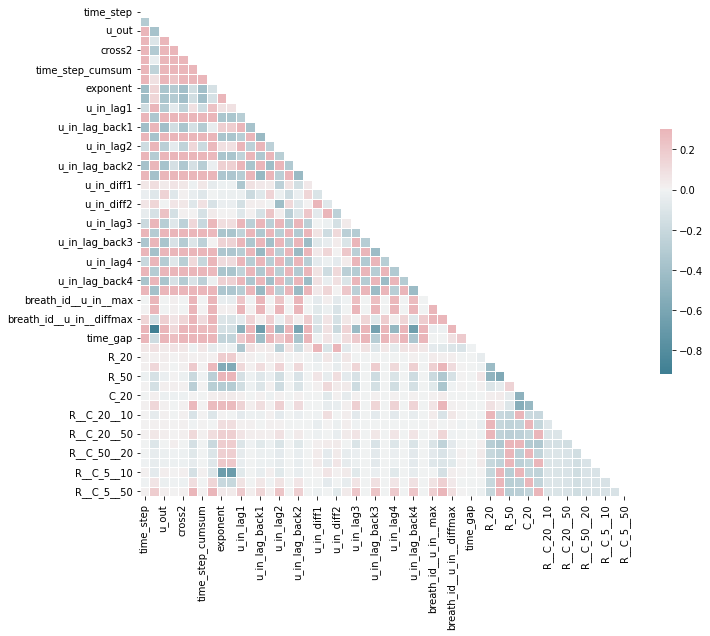

In [15]:
ALL_FEATURES = ALL_FEATURES = [c for c in train.columns if c not in ['id', 'pressure', 'breath_id']]


if DEBUG:
    if len(train) > 1000000:
        corr = train[ALL_FEATURES][::100].corr()
    else:
        corr = train[ALL_FEATURES][::10].corr()
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    f, ax = plt.subplots(figsize=(11, 9))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Tuning Hyperparameters
https://www.kaggle.com/somang1418/tuning-hyperparameters-under-10-minutes-lgbm

https://www.kaggle.com/nicapotato/lgbm-cv-tuning-and-seed-diversification

In [16]:
%%time


def run_tuning(X, y, splits, lgb_params, tune_param_name, tune_param_list, num_boost_round, nfold, verbose_eval, early_stopping_rounds):
    
    results = pd.DataFrame(columns = ["Rounds","Score","STDV", "LB", "Parameters"])
    train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)

    for param_value in tune_param_list:
        print(f"{tune_param_name}: ", param_value)
        lgb_params[tune_param_name] = param_value
        lgb_cv = lgb.cv( 
            params = lgb_params, 
            train_set = train_data, 
            num_boost_round=NUM_BOOST_ROUND, 
            stratified=False, 
            nfold = TOTAL_SPLITS, 
            verbose_eval=VERBOSE_EVAL, 
            seed = RANDOM_SEED, 
            early_stopping_rounds=EARLY_STOPPING_ROUNDS
        )

        optimal_rounds = np.argmin(lgb_cv['rmse-mean'])
        best_cv_score = min(lgb_cv['rmse-mean'])
        print("Optimal Round: {}\nOptimal Score: {} + {}".format(optimal_rounds,best_cv_score,lgb_cv['rmse-stdv'][optimal_rounds]))
        print("###########################################################################################")    

        # store results
        results = results.append({"Rounds": optimal_rounds,
                                  "Score": best_cv_score,
                                  "STDV": lgb_cv['rmse-stdv'][optimal_rounds],
                                  "Parameters": lgb_params}, ignore_index=True)
        with open('results.csv', 'a') as f:
            results.to_csv(f, header=False)    
    return


NUM_BOOST_ROUND = 2000 
EARLY_STOPPING_ROUNDS = 100
VERBOSE_EVAL = 200
TOTAL_SPLITS = 3
LEARNING_RATE = 0.0257
MAX_DEPTH = -1
NUM_LEAVES = 250


tune_params = { 
    'verbose' : -1,
    'task': 'train', 
    'boosting_type': 'gbdt', 
    'objective': 'regression', 
    'metric': 'rmse', 
    "learning_rate": LEARNING_RATE, 
    "num_leaves": 250, 
    "feature_fraction": 0.9, 
    "bagging_fraction": 0.9, 
    'bagging_freq': 4, 
    "max_depth": MAX_DEPTH, 
    #"reg_alpha": 0.3, 
    #"reg_lambda": 0.1, 
    #"min_split_gain":0.2, 
    #"min_child_weight":10, 
    #'zero_as_missing':True 
}

#if HYPER_TUNING:
#    X, y, groups = select_train_data(train, sample_size=10000, ALL_FEATURES) 
#    run_tuning( X, y, splits=3, lgb_params=tune_params, tune_param_name='reg_lambda', tune_param_list=[0.3, 0.5])
#    results = pd.read_csv('./results.csv')
#    pd.set_option('max_colwidth', 800)
#    display(results.sort_values(by="Score",ascending = True))

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 11.2 µs


In [17]:
%%time

def run_train(X, y, groups, run_params, splits, num_boost_round, verbose_eval, early_stopping_rounds ):
    scores = []
    models = []
    f_importances = []
    folds = GroupKFold(n_splits=splits)
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y, groups=groups)):
        print(f'Fold {fold_n+1} started')
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        model = lgb.train(
            run_params, valid_names=["train", "valid"], 
            train_set=lgb.Dataset(X_train, y_train ), 
            num_boost_round = NUM_BOOST_ROUND,
            valid_sets = [lgb.Dataset(X_valid, y_valid)],
            verbose_eval = VERBOSE_EVAL,
            early_stopping_rounds = EARLY_STOPPING_ROUNDS)
        
        y_predicted = model.predict(X_valid)
        f_importances.append(model.feature_importance())
        
        mae_score = mean_absolute_error(y_valid, y_predicted)   
        print(f'MAE: {mae_score}')
        
        mrse_score = math.sqrt(mean_squared_error(y_valid, y_predicted))
        print(f'RMSE: {mrse_score}')

        models.append(model)
        scores.append(mrse_score)
    return scores, models, np.sum(f_importances, axis=0) / TOTAL_SPLITS

#LEARNING_RATE = 0.0257
#MAX_DEPTH = -1
#NUM_LEAVES = 250    

run_params = {
    'verbose': -1, 
    'boosting_type': 'gbdt', 
    'objective': 'regression', 
    'metric': 'mae', 
    'learning_rate': LEARNING_RATE, 
    'num_leaves': NUM_LEAVES, 
    'feature_fraction': 0.9, 
    'bagging_fraction': 0.9, 
    'bagging_freq': 4, 
    'max_depth': -1, 
}

if DEBUG:
    X, y, groups = select_train_data(train, ALL_FEATURES, sample_size=10000 )
    TOTAL_SPLITS = 3
    NUM_BOOST_ROUND = 400 
    EARLY_STOPPING_ROUNDS = 50
    VERBOSE_EVAL = 100    
else:
    X, y, groups = select_train_data(train, ALL_FEATURES, sample_size=70000 )
    TOTAL_SPLITS = 8
    NUM_BOOST_ROUND = 1000 
    EARLY_STOPPING_ROUNDS = 100
    VERBOSE_EVAL = 200
    
scores, models, f_importances = run_train(X, y, groups, run_params, TOTAL_SPLITS, NUM_BOOST_ROUND, VERBOSE_EVAL, EARLY_STOPPING_ROUNDS)
print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))

Original sizes: train: (800000, 51), y_train: (800000,)
Fold 1 started
Training until validation scores don't improve for 50 rounds
[100]	train's l1: 0.842694
[200]	train's l1: 0.592271
[300]	train's l1: 0.54951
[400]	train's l1: 0.529969
Did not meet early stopping. Best iteration is:
[400]	train's l1: 0.529969
MAE: 0.5299694690360681
RMSE: 0.8986990299282323
Fold 2 started
Training until validation scores don't improve for 50 rounds
[100]	train's l1: 0.838905
[200]	train's l1: 0.584949
[300]	train's l1: 0.542696
[400]	train's l1: 0.523182
Did not meet early stopping. Best iteration is:
[400]	train's l1: 0.523182
MAE: 0.5231818692709954
RMSE: 0.8577700024636309
Fold 3 started
Training until validation scores don't improve for 50 rounds
[100]	train's l1: 0.834072
[200]	train's l1: 0.586813
[300]	train's l1: 0.54487
[400]	train's l1: 0.525562
Did not meet early stopping. Best iteration is:
[400]	train's l1: 0.525562
MAE: 0.5255618636237747
RMSE: 0.8627311501549804
CV mean score: 0.8731,

## Feature Importance

In [ ]:
best_model = None
best_score = 99
for i in range(len(scores)):
    if scores[i] < best_score:
        best_score = scores[i]
        best_model = models[i]
        
print(f'BEST SCORE: {best_score}')

In [ ]:
fig = plt.figure(figsize = (15,15)) 
axes = fig.add_subplot(111) 
lgb.plot_importance(best_model,ax = axes,height = 0.5) 
plt.show();

In [ ]:
predicted = []
for model in models:
    predicted.append(model.predict(test[ALL_FEATURES]))

avg_preds = np.zeros(len(predicted[0]))
for pred in predicted:
    avg_preds += pred
avg_pred = avg_preds / len(models)

## Submission

In [ ]:
submission['pressure'] = avg_pred
submission.to_csv('submission.csv', index=False, float_format='%.6f')
submission.head(20)